# DReS-FL Experiment 

- K = 1
- T = 1
- input dimension = 2 -> scalar
- linear regression
- w = [1 1]
- finite field size = [5, 7, 11, 13, 17]
- inputs are selected from {0, 1}
- no relationship between x and y
- the gradient is supposed to be revealed at the end of each training round

Basically, our objective function is $l = (y - xw)^2$ and our gradient is $g = -2(xy - x^2w)$ 

In [3]:
import numpy as np
from lcc.polynomials import LCCPoly, InterpolatedPoly
from mutual_information.estimators.neural.benchmark import neural_estimator_benchmark

In [13]:
def create_encoded_dataset(encoded_data_pol, data_size, encoded_label_pol, alpha):
    encoded_data = np.empty((len(encoded_data_pol), *data_size)) 
    encoded_label = np.empty((len(encoded_label_pol), 1))
    for idx, (data_pol, label_pol) in enumerate(zip(encoded_data_pol, encoded_label_pol)):
        encoded_data[idx] = data_pol(alpha)
        encoded_label[idx][0] = label_pol(alpha)
    return encoded_data, encoded_label

def calculate_gradient_samplewise(encoded_data, encoded_label, curr_weight, p):
    # g = -2(xy - x^2w)
    gradient = np.empty((encoded_data.shape[0], *curr_weight.shape))
    for idx in range(encoded_data.shape[0]):
        data, label = encoded_data[idx], encoded_label[idx]
        gradient[idx] = (label - (data.T @ curr_weight)[0][0]) % p
        gradient[idx] = (data * gradient[idx]) % p
        gradient[idx] = (-2 * gradient[idx]) % p
    gradient = gradient.astype(int)
    return gradient

def main_mi_calculation(data_range, prime, para_param, priv_param, num_of_samples, beta_arr, alpha_arr, weight):
    secret_data = np.random.randint(low=0, high=data_range, size=(num_of_samples, 2, 1))
    secret_label = np.random.randint(low=0, high=data_range, size=(num_of_samples, 1))
    encoded_secret_data_pol = [LCCPoly(beta_arr, [x], para_param, priv_param, prime, size=(2, 1)) for x in secret_data]
    encoded_secret_label_pol = [LCCPoly(beta_arr, [x[0]], para_param, priv_param, prime) for x in secret_label]
    print('pols created')
    
    # client 0
    client_0_encoded_data, client_0_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (2, 1), encoded_secret_label_pol, alpha_arr[0])
    client_0_encoded_gradient = calculate_gradient_samplewise(client_0_encoded_data, client_0_encoded_label, weight, prime)
    
    # client 1
    client_1_encoded_data, client_1_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (2, 1), encoded_secret_label_pol, alpha_arr[1])
    client_1_encoded_gradient = calculate_gradient_samplewise(client_1_encoded_data, client_1_encoded_label, weight, prime)
    
    # client 2
    client_2_encoded_data, client_2_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (2, 1), encoded_secret_label_pol, alpha_arr[2])
    client_2_encoded_gradient = calculate_gradient_samplewise(client_2_encoded_data, client_2_encoded_label, weight, prime)
    print('gradient calculation for each client done')
    
    revealed_gradients = np.empty(client_0_encoded_data.shape)
    revealed_random = np.empty(client_0_encoded_gradient.shape)
    revealed_poly_constructed_coeff = np.empty((client_0_encoded_gradient.shape[0], 2 * (para_param + priv_param - 1) + 1, client_0_encoded_gradient.shape[1], client_0_encoded_gradient.shape[2]))
    for gradient_idx in range(client_0_encoded_gradient.shape[0]):
        revealed_poly = InterpolatedPoly([client_0_encoded_gradient[gradient_idx], client_1_encoded_gradient[gradient_idx], client_2_encoded_gradient[gradient_idx]], alpha_arr, prime)
        revealed_gradients[gradient_idx] = revealed_poly(beta_arr[0])
        revealed_random[gradient_idx] = revealed_poly(beta_arr[1])
        revealed_poly_constructed_coeff[gradient_idx] = revealed_poly.coefficients
    
    # create dataset
    resulting_dataset = np.concatenate([secret_data.reshape(num_of_samples, -1), secret_label, revealed_gradients.reshape(num_of_samples, -1), revealed_random.reshape(num_of_samples, -1), revealed_poly_constructed_coeff.reshape(num_of_samples, -1)], axis=1)
    print('dataset is created')
    
    estimators_all, results_all = neural_estimator_benchmark(resulting_dataset[:, :3], resulting_dataset[:, 7:])
    # estimators_revealed_gradient, results_revealed_gradient = neural_estimator_benchmark(resulting_dataset[:, :3], resulting_dataset[:, 3:5])
    return estimators_all, results_all#, estimators_revealed_gradient, results_revealed_gradient

In [5]:
prime_arr = [5, 7, 11, 13, 17]
data_range_arg = 2
para_param_arg = 1 # K
priv_param_arg = 1 # T

num_of_samples_arg = 5000
beta_arr_arg = [0, 1]
alpha_arr_arg = [2, 3, 4] # number of clients = 3
weight_arg = np.asarray([[1], [1]])

for prime_arg in prime_arr:
    print('###########################')
    print('exp prime: {}'.format(prime_arg))
    main_mi_calculation(data_range_arg, prime_arg, para_param_arg, priv_param_arg, num_of_samples_arg, beta_arr_arg, alpha_arr_arg, weight_arg)
    print('###########################\n')

###########################
exp prime: 5
pols created
gradient calculation for each client done
dataset is created


 12%|██████▋                                              | 1250/10000 [02:02<14:14, 10.24step/s, test=1.87, train=1.93]


Donker Varadhan estimator: 1.88


 10%|█████▏                                              | 1000/10000 [00:04<00:41, 219.11step/s, test=1.83, train=1.86]


MINE estimator: 1.87


 12%|██████▋                                              | 1250/10000 [02:07<14:55,  9.77step/s, test=1.87, train=1.91]


InfoNCE estimator: 1.88


 18%|█████████▎                                           | 1750/10000 [02:47<13:08, 10.47step/s, test=1.86, train=1.92]


NWJ estimator: 1.88


 18%|█████████▎                                           | 1750/10000 [02:10<10:15, 13.39step/s, test=1.38, train=1.39]


Donker Varadhan estimator: 1.39


 10%|█████▏                                              | 1000/10000 [00:03<00:28, 312.05step/s, test=1.37, train=1.31]


MINE estimator: 1.42


  8%|████                                                  | 750/10000 [00:55<11:27, 13.46step/s, test=1.39, train=1.45]


InfoNCE estimator: 1.39


 18%|█████████▎                                           | 1750/10000 [02:10<10:14, 13.43step/s, test=1.38, train=1.39]


NWJ estimator: 1.39
###########################

###########################
exp prime: 7
pols created
gradient calculation for each client done
dataset is created


 20%|██████████▌                                          | 2000/10000 [02:29<09:57, 13.38step/s, test=1.91, train=1.93]


Donker Varadhan estimator: 1.92


  8%|███▉                                                 | 750/10000 [00:02<00:29, 313.75step/s, test=1.84, train=1.67]


MINE estimator: 1.90


 15%|███████▉                                             | 1500/10000 [01:52<10:38, 13.30step/s, test=1.92, train=1.96]


InfoNCE estimator: 1.92


 12%|██████▋                                              | 1250/10000 [01:33<10:51, 13.44step/s, test=1.92, train=1.92]


NWJ estimator: 1.92


 12%|██████▋                                              | 1250/10000 [01:34<10:59, 13.28step/s, test=1.39, train=1.35]


Donker Varadhan estimator: 1.39


  8%|███▉                                                 | 750/10000 [00:02<00:31, 297.11step/s, test=1.36, train=1.18]


MINE estimator: 1.40


  8%|████                                                  | 750/10000 [00:59<12:19, 12.50step/s, test=1.39, train=1.31]


InfoNCE estimator: 1.39


 32%|█████████████████▏                                   | 3250/10000 [04:08<08:36, 13.07step/s, test=1.39, train=1.39]


NWJ estimator: 1.39
###########################

###########################
exp prime: 11
pols created
gradient calculation for each client done
dataset is created


 10%|█████▎                                               | 1000/10000 [01:18<11:49, 12.68step/s, test=1.96, train=2.02]


Donker Varadhan estimator: 1.96


 10%|█████▏                                              | 1000/10000 [00:03<00:29, 309.24step/s, test=1.96, train=1.91]


MINE estimator: 1.99


 10%|█████▎                                               | 1000/10000 [01:16<11:30, 13.04step/s, test=1.96, train=2.01]


InfoNCE estimator: 1.97


 10%|█████▎                                               | 1000/10000 [01:17<11:37, 12.90step/s, test=1.95, train=2.00]


NWJ estimator: 1.96


 18%|█████████▎                                           | 1750/10000 [02:12<10:26, 13.17step/s, test=1.38, train=1.36]


Donker Varadhan estimator: 1.38


 10%|█████▏                                              | 1000/10000 [00:03<00:27, 328.32step/s, test=1.40, train=1.39]


MINE estimator: 1.43


  8%|████                                                  | 750/10000 [00:56<11:41, 13.18step/s, test=1.38, train=1.43]


InfoNCE estimator: 1.38


 28%|██████████████▌                                      | 2750/10000 [03:28<09:10, 13.17step/s, test=1.38, train=1.36]


NWJ estimator: 1.38
###########################

###########################
exp prime: 13
pols created
gradient calculation for each client done
dataset is created


 18%|█████████▎                                           | 1750/10000 [02:13<10:28, 13.13step/s, test=1.96, train=2.02]


Donker Varadhan estimator: 1.97


 15%|███████▊                                            | 1500/10000 [00:04<00:26, 322.81step/s, test=1.97, train=1.87]


MINE estimator: 1.99


 10%|█████▎                                               | 1000/10000 [01:17<11:38, 12.88step/s, test=1.96, train=1.97]


InfoNCE estimator: 1.97


 12%|██████▋                                              | 1250/10000 [01:36<11:15, 12.96step/s, test=1.96, train=2.01]


NWJ estimator: 1.97


 25%|█████████████▎                                       | 2500/10000 [03:09<09:28, 13.20step/s, test=1.38, train=1.41]


Donker Varadhan estimator: 1.39


  8%|███▉                                                 | 750/10000 [00:02<00:29, 314.18step/s, test=1.40, train=1.45]


MINE estimator: 1.41


 15%|███████▉                                             | 1500/10000 [01:52<10:39, 13.30step/s, test=1.39, train=1.43]


InfoNCE estimator: 1.39


 22%|███████████▉                                         | 2250/10000 [02:48<09:41, 13.33step/s, test=1.38, train=1.41]


NWJ estimator: 1.39
###########################

###########################
exp prime: 17
pols created
gradient calculation for each client done
dataset is created


 10%|█████▎                                               | 1000/10000 [01:16<11:25, 13.14step/s, test=1.93, train=2.04]


Donker Varadhan estimator: 1.97


 25%|█████████████                                       | 2500/10000 [00:07<00:21, 354.94step/s, test=1.92, train=2.18]


MINE estimator: 1.96


 12%|██████▋                                              | 1250/10000 [01:34<11:04, 13.17step/s, test=1.97, train=2.02]


InfoNCE estimator: 1.98


 12%|██████▋                                              | 1250/10000 [01:34<11:01, 13.22step/s, test=1.95, train=2.04]


NWJ estimator: 1.97


 20%|██████████▌                                          | 2000/10000 [02:30<10:00, 13.32step/s, test=1.38, train=1.40]


Donker Varadhan estimator: 1.38


  8%|███▉                                                 | 750/10000 [00:02<00:29, 315.64step/s, test=1.32, train=1.45]


MINE estimator: 1.38


 10%|█████▎                                               | 1000/10000 [01:15<11:20, 13.22step/s, test=1.38, train=1.38]


InfoNCE estimator: 1.38


 12%|██████▋                                              | 1250/10000 [01:34<10:58, 13.29step/s, test=1.38, train=1.36]

NWJ estimator: 1.38
###########################


In [15]:
print('###########################')
print('exp prime: {}'.format(19))
main_mi_calculation(data_range_arg, 19, para_param_arg, priv_param_arg, num_of_samples_arg, beta_arr_arg, alpha_arr_arg, weight_arg)
print('###########################\n')

print('###########################')
print('exp prime: {}'.format(23))
main_mi_calculation(data_range_arg, 23, para_param_arg, priv_param_arg, num_of_samples_arg, beta_arr_arg, alpha_arr_arg, weight_arg)
print('###########################\n')

###########################
exp prime: 19


  1%|▎                                                     | 68/10000 [00:41<1:40:26,  1.65step/s, test=???, train=1.79]


pols created
gradient calculation for each client done
dataset is created


 15%|███████▉                                             | 1500/10000 [01:55<10:55, 12.97step/s, test=1.94, train=2.06]


Donker Varadhan estimator: 1.97


 12%|██████▌                                             | 1250/10000 [00:03<00:26, 325.63step/s, test=1.83, train=1.97]


MINE estimator: 1.89


 15%|███████▉                                             | 1500/10000 [01:56<10:57, 12.92step/s, test=1.95, train=2.02]


InfoNCE estimator: 1.96


 15%|███████▉                                             | 1500/10000 [01:55<10:54, 12.98step/s, test=1.95, train=2.05]


NWJ estimator: 1.95
###########################

###########################
exp prime: 23
pols created
gradient calculation for each client done
dataset is created


 15%|███████▉                                             | 1500/10000 [01:55<10:56, 12.96step/s, test=1.98, train=2.03]


Donker Varadhan estimator: 2.00


 10%|█████▏                                              | 1000/10000 [00:03<00:27, 321.53step/s, test=1.88, train=2.05]


MINE estimator: 1.91


 12%|██████▋                                              | 1250/10000 [01:36<11:16, 12.94step/s, test=1.99, train=2.02]


InfoNCE estimator: 2.00


 15%|███████▉                                             | 1500/10000 [01:55<10:53, 13.01step/s, test=1.96, train=2.03]

NWJ estimator: 1.97
###########################


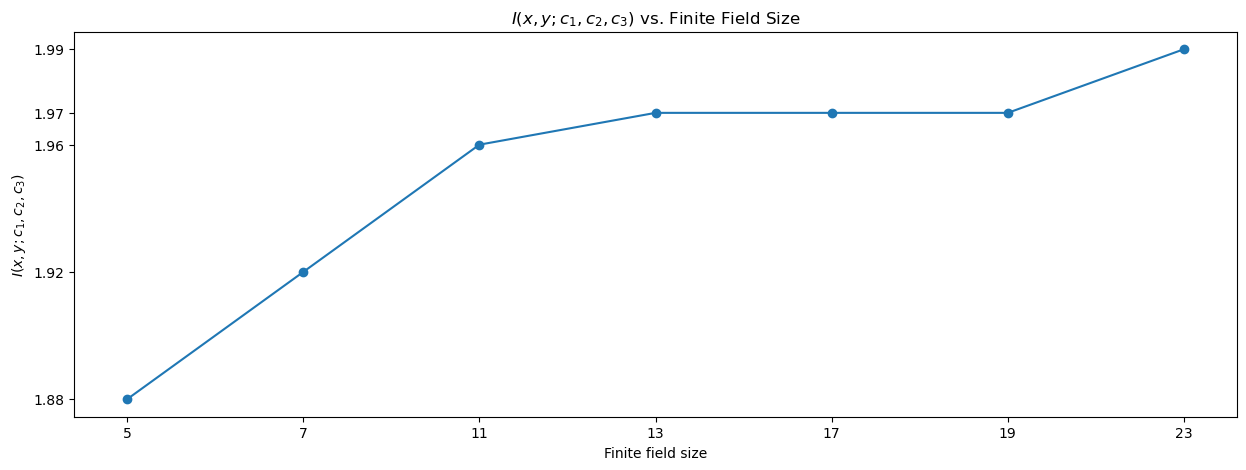

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
plt.plot(list(range(len([*prime_arr, 19, 23]))), [1.88, 1.92, 1.96, 1.97, 1.97, 1.97, 1.99])
plt.scatter(list(range(len([*prime_arr, 19, 23]))), [1.88, 1.92, 1.96, 1.97, 1.97, 1.97, 1.99])
plt.xticks(list(range(len([*prime_arr, 19, 23]))), [*prime_arr, 19, 23])
plt.yticks([1.88, 1.92, 1.96, 1.97, 1.99])
plt.title('$I(x, y; c_1, c_2, c_3)$ vs. Finite Field Size')
plt.ylabel('$I(x, y; c_1, c_2, c_3)$')
plt.xlabel('Finite field size')
plt.show()